Whatsapp Analysis

First we need to install the new packages we will use in this project

In [52]:
#!pip install regex
#!pip install emoji
#!pip install plotly.express
#!pip install wordcloud
#!git clone https://github.com/amueller/word_cloud.git
#%cd word_cloud

In [53]:
#Checking the working directory
#import os
#os.getcwd()

In [54]:
#%cd ..

DATA COLLECTION 


Now we can import the packages to Jupyter 

In [109]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import seaborn as sns
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
import datetime
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### 

In [110]:
def startsWithDateAndTime(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])[ ]?(AM|PM|am|pm)?\]'
    result = re.match(pattern, s)
    if result:
        return True
    return False

Quick test to see if the function is working for this format

In [111]:
startsWithDateAndTime("[2020-04-20 6:46:53] Lance Amstrong: If there was a god, I'd still have both nuts.")

True

Lets grab the authors in the file 

In [112]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Last Name
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getDataPoint(line):   
    splitLine = line.split('] ')
    dateTime = splitLine[0]
    if ',' in dateTime:
      date, time = dateTime.split(',') 
    else:
      date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/Users/laurentrisser/Desktop/dragons.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    fp.readline()
    fp.readline()
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line: 
            break 
        line = line.strip()
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
          line= (line.encode('ascii', 'ignore')).decode("utf-8")
          if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
          else:
            messageBuffer.append(line)

def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%Y-%m-%d").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%Y-%m-%d").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%Y/%m/%d").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%Y/%m/%d").strftime("%Y-%m-%d")
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = df["Date"].apply(dateconv)
df["Date"] = pd.to_datetime(df["Date"])

DATA MANIPULATION

The block below will be fixing the dates

In [60]:
df

,Date,Time,Author,Message
0,2019-10-15,1:38:00 PM,Denis Weber,Jean pierre l'oeuil du Tigre
1,2019-10-15,1:38:44 PM,Gilles Jean Pierre,Moi je me suis arrêté aux garage en vélo noir ...
2,2019-10-15,1:38:54 PM,Denis Weber,Pff il n'y a que fabien pour voir le ridley
3,2019-10-15,1:40:20 PM,Fabien Cop,Non mais les p'tits culs je les ai vu aussi 🤓
4,2019-10-15,1:41:54 PM,Gilles Jean Pierre,"Sauf denis , trop préoccupé pour pas que l’on ..."
...,...,...,...,...
8352,2020-08-15,6:34:11 PM,Cyrille Millet Pfuch,Ok pour moi 8h30 aux Dragoons en route
8353,2020-08-16,9:51:27 AM,Hervé Dupont,"Je confirme, y’a une différence entre les pros..."
8354,2020-08-16,9:52:38 AM,Denis Weber,Nous aussi on avance... mais pas à la même vit...
8355,2020-08-16,9:54:22 AM,Hervé Dupont,Ouais comme un enfant et un adulte 😂


In [61]:
#Quick look at the column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8357 entries, 0 to 8356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     8357 non-null   datetime64[ns]
 1   Time     8357 non-null   object        
 2   Author   8337 non-null   object        
 3   Message  8357 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 261.3+ KB


In [62]:
#looking at the different Authors' names
df.Author.unique()

array(['Denis Weber', 'Gilles Jean Pierre', 'Fabien Cop',
       'Aurelien Pointereau', 'Rodrigue Voison', 'Didier Muckensturm',
       'Cyrille Millet Pfuch', 'Hervé Stratenmeyer', 'Laurent', 'Marc',
       'Eric Pally', 'Pierre', 'FX Laurent', 'Herv Dupont', None,
       'Hervé Dupont', 'Herv Stratenmeyer', 'Matthieu Liehn',
       'Alexandre Risser'], dtype=object)

In [63]:
#Replacing names with surnames
#df = df[df['Author'].apply(valid_user)]
#df.loc[(df.Author == 'Denis Weber'), 'Author'] = 'Chris Froome'
#df.loc[(df.Author == 'Gilles Jean Pierre'), 'Author'] = 'Egan Bernal' 
#df.loc[(df.Author == 'Fabien Cop'), 'Author'] = 'Alberto Contador' 
#df.loc[(df.Author == 'Aurelien Pointereau'), 'Author'] = 'Nairo Quintana' 
#df.loc[(df.Author == 'Rodrigue Voison'), 'Author'] = 'Romain Bardet' 
#df.loc[(df.Author == 'Didier Muckensturm'), 'Author'] = 'Vincenzo Nibali' 
#df.loc[(df.Author == 'Cyrille Millet Pfuch'), 'Author'] = 'Peter Sagan' 
#df.loc[(df.Author == 'Hervé Stratenmeyer'), 'Author'] = 'Emanuel Buchmann' 
#df.loc[(df.Author == 'Laurent'), 'Author'] = 'Julian Alaphillipe' 
#df.loc[(df.Author == 'Marc'), 'Author'] = 'Tony Gallopin' 
#df.loc[(df.Author == 'Eric Pally'), 'Author'] = 'Thibaut Pinot' 
#df.loc[(df.Author == 'Pierre'), 'Author'] = 'Tom Dumoulin' 
#df.loc[(df.Author == 'FX Laurent'), 'Author'] = 'Fabio Aru' 
#df.loc[(df.Author == 'Herv Dupont'), 'Author'] = 'Adam Yates' 
#df.loc[(df.Author == 'Hervé Dupont'), 'Author'] = 'Adam Yates' 
#df.loc[(df.Author == 'Herv Stratenmeyer'), 'Author'] = 'Warren Barguil' 
#df.loc[(df.Author == 'Matthieu Liehn'), 'Author'] = 'Wout Van Aert' 
#df.loc[(df.Author == 'Alexandre Risser'), 'Author'] = 'Bauke Mollema' 
#df = df[df['name'] != '<redacted>']
df['Author'].unique()


array(['Denis Weber', 'Gilles Jean Pierre', 'Fabien Cop',
       'Aurelien Pointereau', 'Rodrigue Voison', 'Didier Muckensturm',
       'Cyrille Millet Pfuch', 'Hervé Stratenmeyer', 'Laurent', 'Marc',
       'Eric Pally', 'Pierre', 'FX Laurent', 'Herv Dupont', None,
       'Hervé Dupont', 'Herv Stratenmeyer', 'Matthieu Liehn',
       'Alexandre Risser'], dtype=object)

In [64]:
#Dropping rows with NA value
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8337 entries, 0 to 8356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     8337 non-null   datetime64[ns]
 1   Time     8337 non-null   object        
 2   Author   8337 non-null   object        
 3   Message  8337 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 325.7+ KB


In [65]:
#Since we did not attach the media, once there is a media sent in the chat its creating the message 'image omitted'
#The script below is counting one media = +1 in the column media_messages
media_messages = df[df['Message'] == 'image omitted'].shape[0]
print(media_messages)

717


In [66]:
#Create a new column emoji and report the type of emoji in the message
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    flags = regex.findall(u'[\U0001F1E6-\U0001F1FF]', text) 

    return emoji_list

df["emoji"] = df["Message"].apply(split_count)

<ipython-input-66-098a4318602f>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
emojis = sum(df['emoji'].str.len())
print(emojis)

2818


In [68]:
total_messages = df.shape[0]
print(total_messages)

8337


In [69]:
#Create a colum urlcount and count +1 once there is a link shared.
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

<ipython-input-69-9444d8661d4d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
#Sum up the number of links shared on the group
links = np.sum(df.urlcount)

In [71]:
#Summary of the data
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 8337
Media: 717
Emojis: 2818
Links: 229


In [72]:
media_messages_df = df[(df['Message'] == 'image omitted')|(df['Message'] == 'video omitted')]

In [73]:
sticker_messages_df = df[df['Message'] == 'sticker omitted']
sticker_messages_df

,Date,Time,Author,Message,emoji,urlcount
3121,2020-03-22,9:23:04 AM,Fabien Cop,sticker omitted,[],0
3933,2020-04-11,10:23:06 AM,Aurelien Pointereau,sticker omitted,[],0


In [74]:
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(sticker_messages_df.index)

In [75]:
#This block will create new columns and add it to the current the dataframe
#Create a new column Letter_count
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
#Create a new column Word_count
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
#Create a new column for 1 row = 1 
messages_df["MessageCount"]=1
#Create a new column emoji count
messages_df["emojicount"]= df['emoji'].str.len()
#Create a new column ratio number of words per emoji
messages_df["ratio_word_emoji"]= messages_df['Word_Count']/messages_df['emojicount']
#Replace infinite value by 0
messages_df["ratio_word_emoji"].replace(np.inf, 0, inplace=True)

In [76]:
messages_df['Author'] = messages_df['Author'].astype('str') 

In [77]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7585 entries, 0 to 8356
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              7585 non-null   datetime64[ns]
 1   Time              7585 non-null   object        
 2   Author            7585 non-null   object        
 3   Message           7585 non-null   object        
 4   emoji             7585 non-null   object        
 5   urlcount          7585 non-null   int64         
 6   Letter_Count      7585 non-null   int64         
 7   Word_Count        7585 non-null   int64         
 8   MessageCount      7585 non-null   int64         
 9   emojicount        7585 non-null   int64         
 10  ratio_word_emoji  7585 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 711.1+ KB


In [78]:
messages_df.tail(10)

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount,emojicount,ratio_word_emoji
8346,2020-08-15,3:52:45 PM,Hervé Dupont,"Oui, je me plains pas 👌",[👌],0,23,6,1,1,6.0
8347,2020-08-15,4:56:59 PM,Laurent,bon vue que je risque de publier un article su...,[],0,83,16,1,0,0.0
8349,2020-08-15,4:57:41 PM,Laurent,Egan Bernal c'est celui qui écrit le plus de m...,[],0,52,11,1,0,0.0
8350,2020-08-15,4:58:43 PM,Didier Muckensturm,Toi t'es pas net 😄,[😄],0,18,5,1,1,5.0
8351,2020-08-15,5:00:13 PM,Gilles Jean Pierre,Moi je dois être celui qui dit le plus d’âneri...,[😂],0,50,11,1,1,11.0
8352,2020-08-15,6:34:11 PM,Cyrille Millet Pfuch,Ok pour moi 8h30 aux Dragoons en route,[],0,38,8,1,0,0.0
8353,2020-08-16,9:51:27 AM,Hervé Dupont,"Je confirme, y’a une différence entre les pros...",[],0,91,18,1,0,0.0
8354,2020-08-16,9:52:38 AM,Denis Weber,Nous aussi on avance... mais pas à la même vit...,"[🚴‍♂️, 🚵‍♂️]",0,59,11,1,2,5.5
8355,2020-08-16,9:54:22 AM,Hervé Dupont,Ouais comme un enfant et un adulte 😂,[😂],0,36,8,1,1,8.0
8356,2020-08-16,9:56:08 AM,Gilles Jean Pierre,Ils ont entre 25 et 32 ans d’âge moyens .. moi...,[],0,167,39,1,0,0.0


In [79]:
#Exporting the dataframe into a csv file
messages_df.to_csv(r'/Users/laurentrisser/Desktop/data.csv', index = False)

In [80]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
    
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  #sticker conists of stickers messages
  stickers = sticker_messages_df[sticker_messages_df['Author'] == l[i]].shape[0]
  print('Sticker Messages Sent', stickers)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)
  ratio = (np.average(req_df['ratio_word_emoji']))
  print('Avg Emoji', ratio)
  print()

Stats of Denis Weber -
Messages Sent 1194
Words per message 8.108877721943049
Media Messages Sent 50
Sticker Messages Sent 0
Emojis Sent 357
Links Sent 9
Avg Emoji 1.1970965940815188

Stats of Gilles Jean Pierre -
Messages Sent 1160
Words per message 10.14051724137931
Media Messages Sent 176
Sticker Messages Sent 0
Emojis Sent 655
Links Sent 6
Avg Emoji 1.6167775136740654

Stats of Fabien Cop -
Messages Sent 428
Words per message 7.168224299065421
Media Messages Sent 19
Sticker Messages Sent 1
Emojis Sent 196
Links Sent 1
Avg Emoji 2.916277258566978

Stats of Aurelien Pointereau -
Messages Sent 917
Words per message 8.223555070883314
Media Messages Sent 117
Sticker Messages Sent 1
Emojis Sent 257
Links Sent 117
Avg Emoji 1.9231188658669576

Stats of Rodrigue Voison -
Messages Sent 195
Words per message 15.153846153846153
Media Messages Sent 16
Sticker Messages Sent 0
Emojis Sent 64
Links Sent 16
Avg Emoji 3.405982905982906

Stats of Didier Muckensturm -
Messages Sent 1456
Words per mes

In [81]:
#Checking the number of unique emoji
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

143


In [82]:
#List of all the emojis used with the frequency
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 817), ('😁', 290), ('😄', 209), ('👍🏻', 182), ('😉', 163), ('👍', 130), ('😜', 87), ('😅', 80), ('🤣', 75), ('🤔', 62), ('😀', 54), ('😝', 48), ('😱', 40), ('🤪', 33), ('😆', 32), ('😃', 29), ('🍾', 23), ('😊', 17), ('😭', 16), ('💪', 16), ('😎', 14), ('😡', 14), ('👌', 14), ('😍', 12), ('❄', 12), ('😩', 12), ('🙄', 10), ('🍺', 10), ('🍻', 10), ('☹️', 10), ('😢', 10), ('😯', 9), ('☃', 9), ('👍🏼', 9), ('🚴\u200d♂️', 9), ('😒', 8), ('😤', 8), ('😋', 7), ('🥂', 7), ('😓', 6), ('😙', 6), ('🙃', 6), ('😬', 6), ('🧐', 6), ('🚴', 6), ('😷', 5), ('🚲', 5), ('💶', 5), ('🏃🏽', 4), ('😛', 4), ('☺', 4), ('🍌', 4), ('🙂', 4), ('🤗', 4), ('🥵', 4), ('🤮', 4), ('🤫', 4), ('🥨', 4), ('🍷', 4), ('😳', 4), ('🤥', 3), ('😨', 3), ('☁️', 3), ('😰', 3), ('🤞', 3), ('⛄', 3), ('😘', 3), ('🤢', 3), ('🤘', 3), ('🤓', 2), ('🤷🏻\u200d♂', 2), ('🤒', 2), ('😮', 2), ('⛷️', 2), ('💪🏻', 2), ('🌧', 2), ('🇨🇵', 2), ('🎁', 2), ('🎄', 2), ('😈', 2), ('🙌', 2), ('🦵', 2), ('🐌', 2), ('😵', 2), ('🥳', 2), ('☔', 2), ('🏍', 2), ('🍕', 2), ('👨\u200d💻', 2), ('😏', 2), ('🤴🏻', 1), ('✈️', 1), ('😟', 1),

In [83]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])

In [84]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [85]:
# Creates a list of unique Authors
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Denis Weber


Emoji Distribution for Gilles Jean Pierre


Emoji Distribution for Fabien Cop


Emoji Distribution for Aurelien Pointereau


Emoji Distribution for Rodrigue Voison


Emoji Distribution for Didier Muckensturm


Emoji Distribution for Hervé Stratenmeyer


Emoji Distribution for Laurent


Emoji Distribution for Cyrille Millet Pfuch


Emoji Distribution for Marc


Emoji Distribution for Eric Pally


Emoji Distribution for Pierre


Emoji Distribution for FX Laurent


Emoji Distribution for Hervé Dupont


Emoji Distribution for Matthieu Liehn


Emoji Distribution for Alexandre Risser


Text(0, 0.5, 'Date')

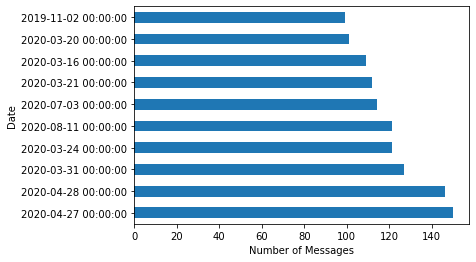

In [86]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

In [87]:
def dayofweek(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(dayofweek)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,1600]
    )),
  showlegend=False
)
fig.show()

In [88]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.show()

In [90]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="Word_Count", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "yellow","goldenrod", "magenta"],
             title="Number of words per Author"
            )

fig.show()

In [91]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "yellow","goldenrod", "magenta"],
             title="Number of messages per Author"
            )
fig.show()

In [92]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="emojicount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "yellow","goldenrod", "magenta"],
             title="Emoji Count per Author"
            )

fig.show()

In [93]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="urlcount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "yellow","goldenrod", "magenta"],
             title="URL Count per Author"
            )

fig.show()

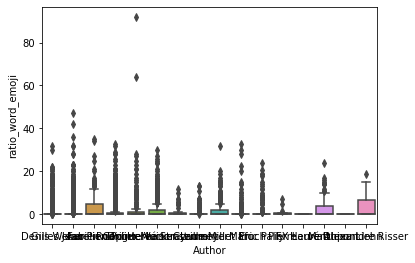

In [94]:
ax = sns.boxplot(x="Author", y="ratio_word_emoji", data=messages_df)


In [95]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                              2020-01-02 00:00:00
Time                                                       5:10:57 PM
Author                                                         Pierre
Message             Dis, papa, c’est quoi, un Alsacien? Ce n'est p...
emoji                                                              []
urlcount                                                            0
Letter_Count                                                     2426
Word_Count                                                        427
MessageCount                                                        1
emojicount                                                          0
ratio_word_emoji                                                    0
Name: 1468, dtype: object

Text(0, 0.5, 'Frequency')

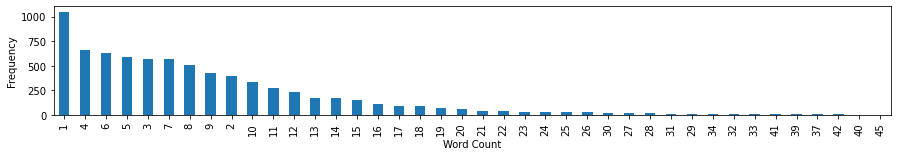

In [96]:
plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

In [97]:
# Import packages
import numpy as np
from PIL import Image
# Import image to np.array
mask = np.array(Image.open('mask.png'))

In [98]:
text = " ".join(review for review in df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 345625 words in all the messages.


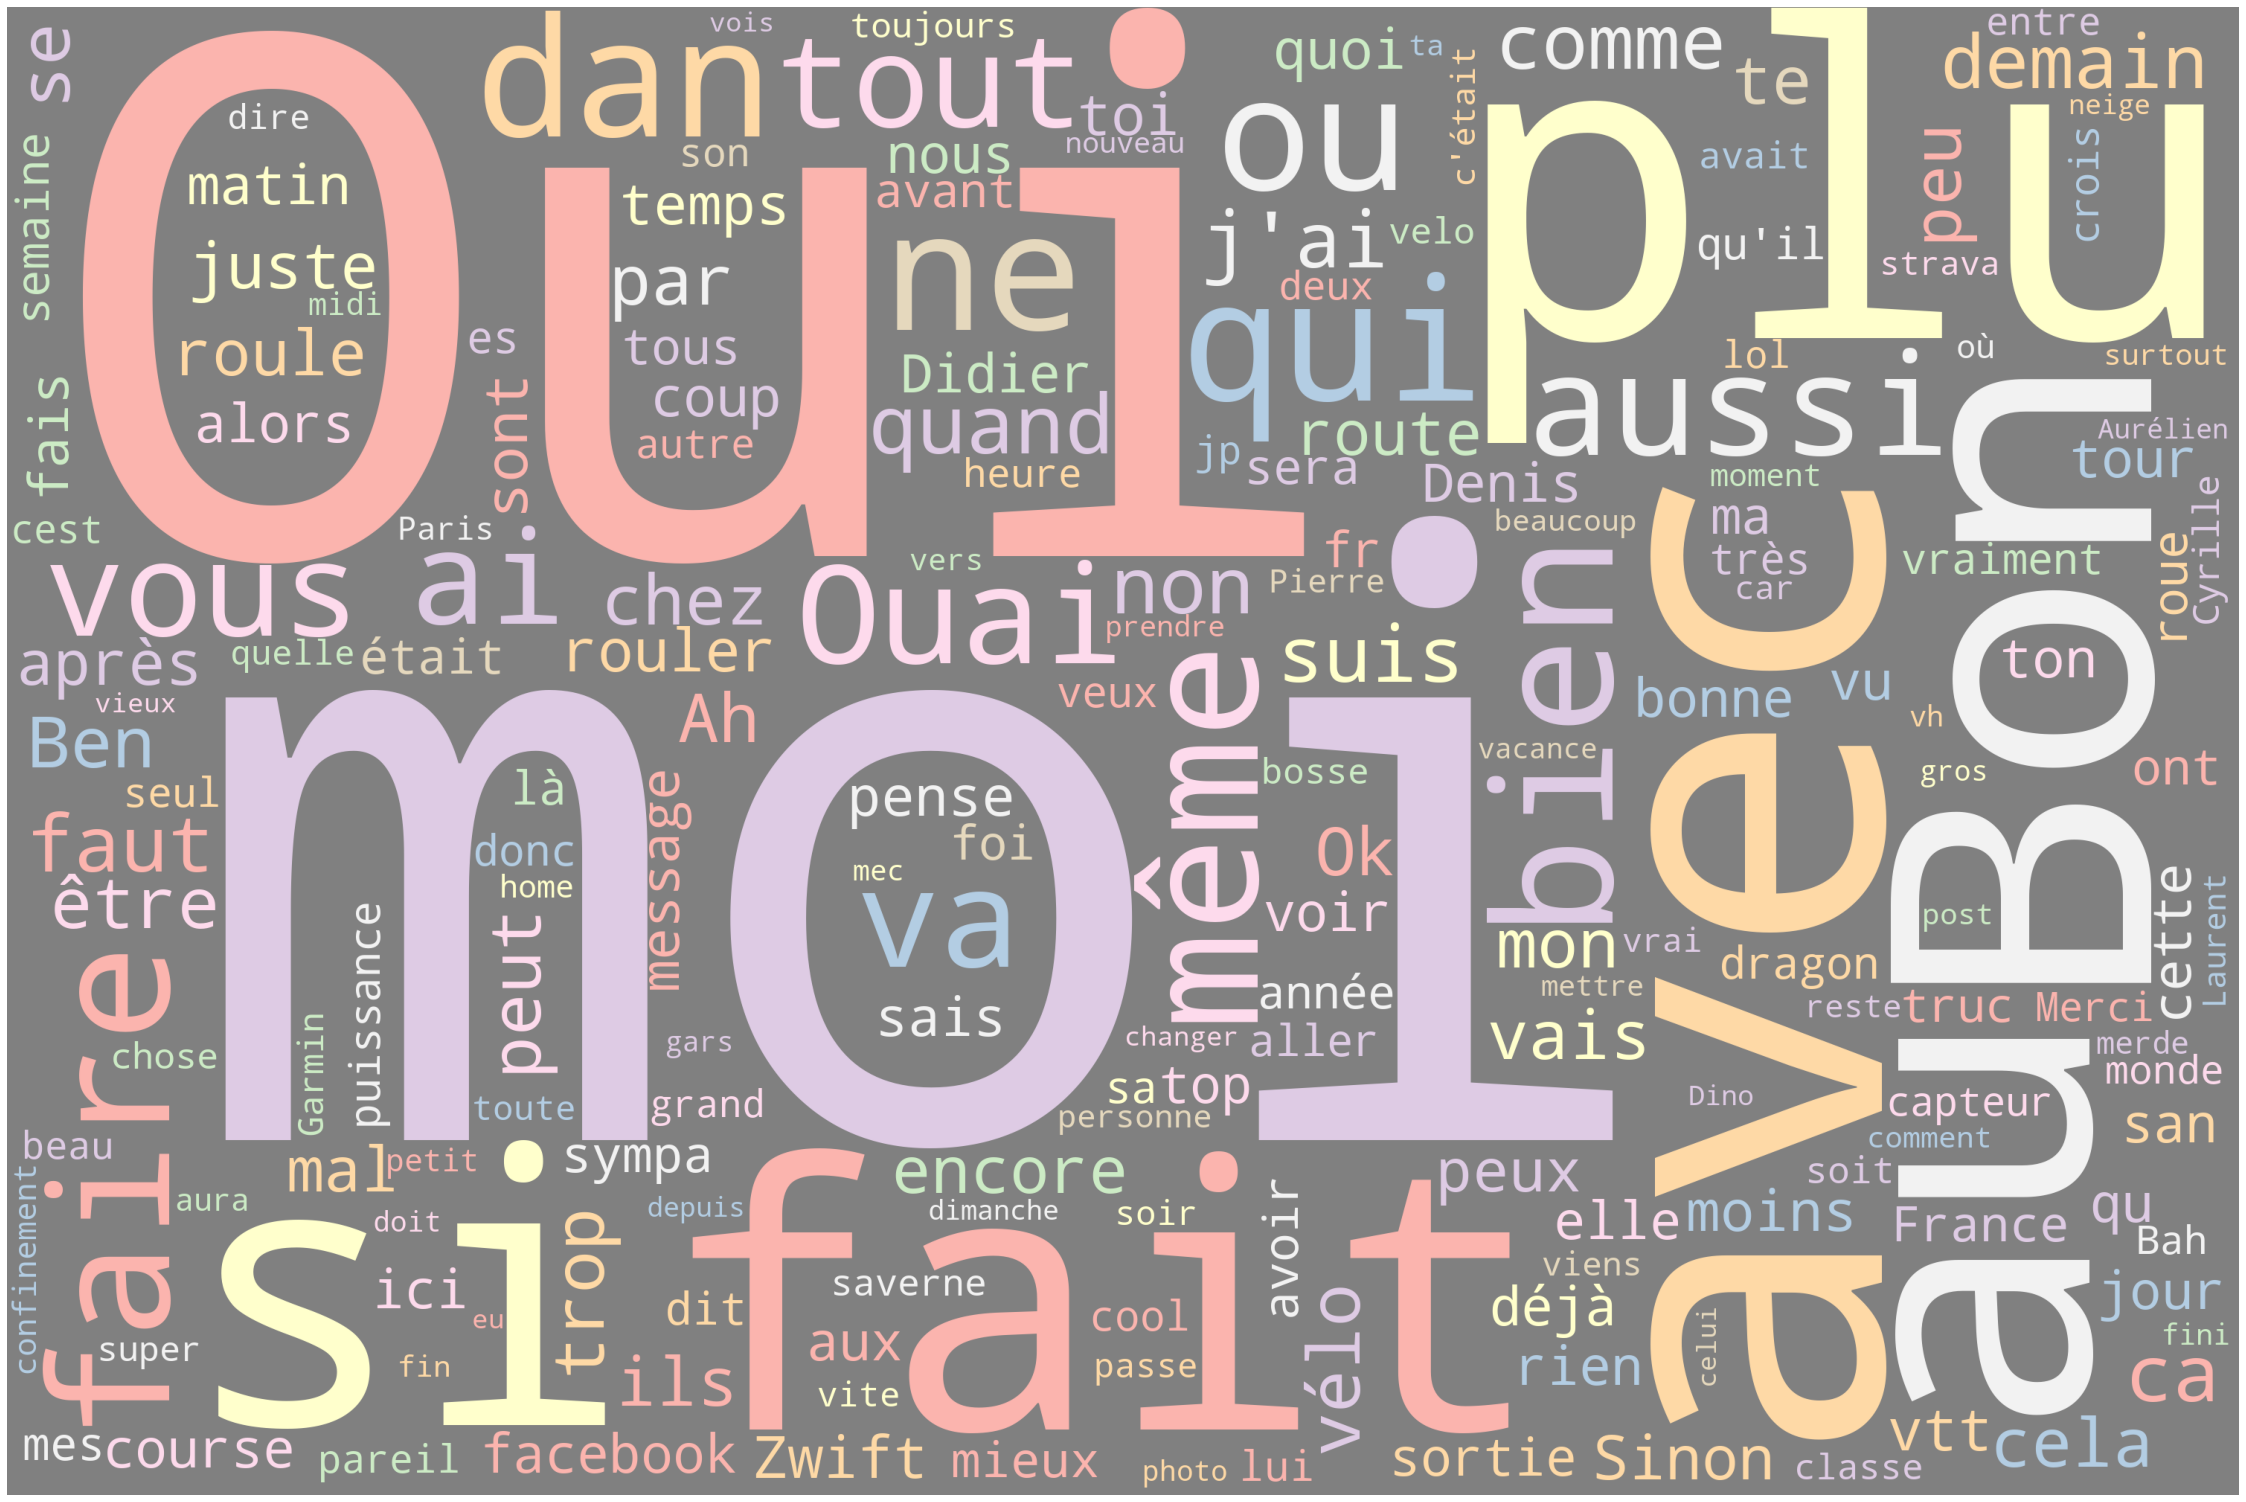

In [99]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    
STOPWORDS.update(['video','deleted',"c'est",'image','omitted','le', 'la','de','en','je','tu','et','pa','un','des','i','ça','les','il', 'pas','est','pour','que','c/est', 'sur', 'une', 'mai','du', 'mais','https','ce'])

# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='grey', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

In [108]:
# initializing the string and the word
word = "moi"
## splitting the string at space
words = text.split()
## initializing count variable to 0
count = 0
## iterating over the list
for w in words:
   ## checking the match of the words
   if w == word:
      ## incrementint count on match
      count += 1
## printing the count
print(count)

214


In [104]:
# initializing the string and the word
word = "bière"
## splitting the string at space
words = text.split()
## initializing count variable to 0
count = 0
## iterating over the list
for w in words:
   ## checking the match of the words
   if w == word:
      ## incrementint count on match
      count += 1
## printing the count
print(count)

17


In [ ]:
FUTURE PROJECTS

occurence of bike vs beer

number of words per emoji

diversity of emoji